In [1]:
import numpy as np
import torch
import torch.nn as nn
from huggingface_hub import hf_hub_download
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

tokenizer =  AutoTokenizer.from_pretrained("google/gemma-2-2b")
path_to_params = hf_hub_download(
    repo_id="google/gemma-scope-2b-pt-res",
    filename="layer_20/width_16k/average_l0_71/params.npz",
    force_download=False,
)


# This is from the GemmaScope tutorial
# https://colab.research.google.com/drive/17dQFYUYnuKnP6OwQPH9v_GSYUW5aj-Rp#scrollTo=WYfvS97fAFzq
class JumpReLUSAE(nn.Module):
  def __init__(self, d_model, d_sae):
    super().__init__()
    self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
    self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
    self.threshold = nn.Parameter(torch.zeros(d_sae))
    self.b_enc = nn.Parameter(torch.zeros(d_sae))
    self.b_dec = nn.Parameter(torch.zeros(d_model))

  def encode(self, input_acts):
    pre_acts = input_acts @ self.W_enc + self.b_enc
    mask = (pre_acts > self.threshold)
    #print(pre_acts.shape)
    #print(torch.nonzero(mask).shape)
    acts = mask * torch.nn.functional.relu(pre_acts)
    return acts

  def decode(self, acts):
    return acts @ self.W_dec + self.b_dec

  def forward(self, acts):
    acts = self.encode(acts)
    recon = self.decode(acts)
    return recon
  
  @classmethod
  def from_pretrained(cls, path,type,device):
    path_to_params = hf_hub_download(
    repo_id="google/gemma-scope-9b-pt-"+type,
    filename=f"{path}/params.npz",
    force_download=False,
    )
    params = np.load(path_to_params)
    pt_params = {k: torch.from_numpy(v) for k, v in params.items()}
    model = cls(params['W_enc'].shape[0], params['W_enc'].shape[1])
    model.load_state_dict(pt_params)
    if device == "cuda":
        model.cuda()
    return model

In [2]:
# Create an instance of your SAE model
input_dim = 784  # Adjust according to your data
hidden_dim = 32  # Adjust according to your model
model = JumpReLUSAE(input_dim, hidden_dim)

params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v) for k, v in params.items()}

In [3]:
{k:v.shape for k, v in pt_params.items()}

{'W_dec': torch.Size([16384, 2304]),
 'W_enc': torch.Size([2304, 16384]),
 'b_dec': torch.Size([2304]),
 'b_enc': torch.Size([16384]),
 'threshold': torch.Size([16384])}

In [4]:
pt_params["W_enc"].norm(dim=0)

tensor([1.2101, 1.1695, 0.9836,  ..., 1.0630, 0.9997, 1.1070])

In [5]:
sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1])
sae.load_state_dict(pt_params)

<All keys matched successfully>

In [6]:
# The feature vectors can be accessed as the Decoder Weights of the SAE (sae.W_dec)
feature_vecs = sae.W_dec
feature_vecs

Parameter containing:
tensor([[ 0.0095, -0.0136,  0.0219,  ..., -0.0163,  0.0090, -0.0098],
        [ 0.0137, -0.0062, -0.0104,  ...,  0.0265,  0.0315, -0.0173],
        [ 0.0373, -0.0551, -0.0459,  ..., -0.0284,  0.0310, -0.0210],
        ...,
        [ 0.0158, -0.0077, -0.0370,  ...,  0.0170, -0.0030,  0.0101],
        [ 0.0101,  0.0286,  0.0651,  ..., -0.0257, -0.0170,  0.0249],
        [ 0.0087, -0.0101, -0.0099,  ..., -0.0067, -0.0082, -0.0268]],
       requires_grad=True)

In [7]:
feature_vecs.shape

torch.Size([16384, 2304])

/Users/School/miniconda3/envs/csci1470/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/School/miniconda3/envs/csci1470/lib/python3.10/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

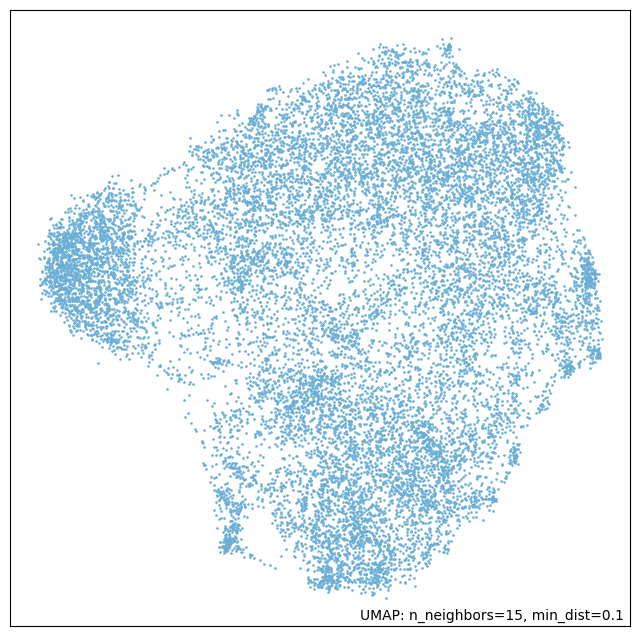

In [8]:
import umap
import matplotlib.pyplot as plt
import umap.plot
data_np = feature_vecs.detach().numpy()
mapper = umap.UMAP().fit(data_np)
umap.plot.points(mapper)

In [9]:
# color dots (features) in umap based on POS tags
# find the POS label for each feature based on which POS has the highest activation based on the activations in that feature

In [10]:

from nnsight import LanguageModel
from datasets import load_dataset
import transformer_lens.utils as utils
import spacy
import networkx as nx
from safetensors.numpy import load_file
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
import json
from spacy.tokens import Token
from itertools import accumulate
from collections import defaultdict
import random


TOTAL_BATCHES = 39039
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("sentencizer")

Token.set_extension("custom_tag", default=0, force=True)

def get_context(loc, k: int, tokens: torch.Tensor, tokenizer) -> list[str]:
    doc = tokens[loc[0]]
    context = doc[loc[1]-k:loc[1]+k]
    return tokenizer.batch_decode(context)

def get_batch_text(n: int, tokens: torch.Tensor, tokenizer) -> list[str]:
    """
    Returns the nth batch from the given tokens tensor as a list of strings using the given tokenizer.
    
    Args:
        n (int): Index of the batch to retrieve.
        tokens (torch.Tensor): Tokens tensor to retrieve from.
        tokenizer (transformer_lens.utils.LanguageModel.tokenizer): Tokenizer to use for decoding.
    
    Returns:
        list[str]: List of strings in the nth batch.
    """
    assert(tokens.ndim == 2 and tokens.shape[1] == 256)
    if n >= len(tokens):
        return None
    doc = tokens[n]
    return tokenizer.batch_decode(doc)

def load_tokens(tokenizer_name, dataset_name):
    """
    Loads tokens from finetuned gemma model and shuffles them.
    Returns:
        tokens (list of lists of int): list of tokenized sentences where each sentence is a list of int.
    """
    tokenizer = LanguageModel(tokenizer_name).tokenizer
    data = load_dataset(dataset_name, name="", split="train")
    tokens = utils.tokenize_and_concatenate(data, tokenizer, max_length=256,column_name="text")
    tokens = tokens.shuffle(22)["tokens"]
    return tokens, tokenizer

def load_activations(path):
    feature_dict = load_file(path)
    activations,locations = feature_dict['activations'], feature_dict['locations']
    locations = torch.tensor(locations.astype(np.int64))
    return activations, locations

def position_to_char_indice(context: list[str], position: int) -> int:
    char_indices = list(accumulate(len(s) for s in context))
    character_position = char_indices[position]
    return character_position


def positions_to_char_indices(context: list[str], token_positions: list[int]) -> list[int]:
    # Concatenate all context strings to form a single string
    char_indices = [0] + list(accumulate(len(s) for s in context))
    character_positions = [char_indices[position] for position in token_positions]
    return character_positions

context = ["I", "like", "rock", "climbing"]
positions = [0, 2]
char_pos = positions_to_char_indices(context, positions)
assert(char_pos == [0,5])

#Context is the sentence broken into tokens without punctuation marks and with spaces preserved. Doc is the sentence spacy Doc.
def make_parse_tree(context: list[str], doc : spacy.tokens.Doc, positions: list[int], activations: list[float]) -> spacy.tokens.Token:
    #this is necessary
    #positions = [position - 1  if position > 0 else position for position in positions]
    print(f'[MAKE_PARSE] positions are {positions}')
    a = [context[position] for position in positions]
    print(f'[MAKE_PARSE] {context=} a are {a} ')
    character_positions = positions_to_char_indices(context, positions)

    #Set character indices at various activations to value.
    for pos, act in zip(character_positions, activations):
        activation_node = None
        for token in doc:
            print(f'{token.idx} {pos} {token.idx+len(token)} {token.text=} ')
            if (int(token.idx) <= pos <= int(token.idx + len(token))):
                activation_node = token
        activation_node._.custom_tag = act
    # Find the root node (the one with dep_ == "ROOT")
    root_node = next(node for node in list(doc)[::-1] if node.dep_ == "ROOT")
    return root_node

## Define joint parse tree from individual parse trees.
def joint_parse_tree(contexts: list[list[str]], 
                     doc: list[spacy.tokens.Doc], 
                     positions: list[list[int]],
                     activations: list[list[float]]):
    #
    for context, doc, pos, act in zip(contexts, doc, positions, activations):
        parse_tree = make_parse_tree(context, doc, pos, act)
    #TODO
    return None


def node_to_dict(token):
    return {
        "text": token.text,
        "lemma": token.lemma_,
        "pos": token.pos_,
        "dep": token.dep_,
        "tag": float(token._.custom_tag),
        "children": [node_to_dict(child) for child in token.children]  # Recursively add children
    }

def jsonify(root_token):
    """Converts a spaCy root node and its entire dependency tree to a JSON string."""
    root_dict = node_to_dict(root_token)
    return json.dumps(root_dict, indent=4)

def ttnp(tensor):
    return tensor.detach().cpu().item()

#Returns position-activation dicts by number of features.
def batch_dicts(n, activations, locations, k=12):
    total_batches = TOTAL_BATCHES
    batch_dicts = [{'i': i, 'positions': [], 'activations': []} for i in range(0, total_batches + 1)]
    for location, activation in zip(locations, activations):
        d = batch_dicts[location[0]]
        d['positions'].append(int(ttnp(location[1]))) #location[0] is batch, location[1] is activation
        d['activations'].append(activation)
    
    #sort by max activation
    batchdict_tuple = [(d, max(d['activations']) if d['activations'] else float('-inf')) for d in batch_dicts]
    sorted_tuples = sorted(batchdict_tuple, key=lambda x: x[1], reverse=True)[:k]
    top_n_dicts = [d for d, _ in sorted_tuples[:n]]
    return top_n_dicts

def get_sentence_at_index(doc, char_index):
    for sent in doc.sents:
        if sent.start_char <= char_index < sent.end_char:
            sent_tokens = [token.text for token in sent]
            return sent_tokens, sent, sent.start_char, sent.end_char
    raise Exception("No sentence at index")

def get_token_idx(string_list: list[str], char_index: int):
    # Concatenate the list of strings into a single string
    current_length = 0
    for i, s in enumerate(string_list):
        current_length += len(s)
        if current_length >= char_index:
            return i  
    raise Exception(f"Char index {char_index} not found in List: length {current_length}")

context = ["I", "like", "rock", "climbing"]
assert(get_token_idx(context, 4) == 1)
assert(get_token_idx(context, 8) == 2)

# Return the part of speech most active.
# Return the number of contiguous tokens / scale metrics.
def get_statistics(n, activations, locations, tokens, tokenizer) -> dict:
    idx = locations[:,2]== n
    locations = locations[idx]
    a = activations[idx]
    activations = np.array(random.sample(a.tolist(), (len(a)//5))) if 100 < (len(a)//5) else np.array(random.sample(a.tolist(), 100))
    num_activations = len(activations)
    avg_act = np.mean(activations)
    pos_pcts = {}
    #we want all activations and positions above threshold. 
    filtered_locations, filtered_activations = zip(*[(location, activation) 
                    for (location, activation) in zip(locations, activations)
                    if avg_act <= activation])
    
    pos_pcts = defaultdict()
    #For each location, add the activation to the corresponding part of speech category
    for loc, act in zip(filtered_locations, filtered_activations):
        WINDOW_SIZE = 3
        batch = get_context(loc, WINDOW_SIZE, tokens, tokenizer)
        #print(f'{batch=}')
        if len(batch) == 2 * WINDOW_SIZE:
            char_idx = position_to_char_indice(batch, WINDOW_SIZE) #token index to char index
            doc = nlp("".join(batch))
            active_token = next((token for token in doc 
                                if token.idx <= char_idx < token.idx + len(token)), None)
            if active_token:
                pos = active_token.pos_
                omit_pos = ['PUNCT', 'SYM', 'X', 'EOL', 'SPACE']
                if pos not in omit_pos:
                    pos_pcts[pos] = pos_pcts.get(pos, 0) + act
    act_sum = sum(pos_pcts.values())
    #Create a dictionary with the percentage of activations for each part of speech
    pos_pcts = {k: float(v / act_sum) for k, v in pos_pcts.items()}
    statistics = {
        'num_activations': num_activations
        , 'pos_pcts': pos_pcts
    }
    return statistics


def visualize_feature(n, activations, 
                      locations, tokens, tokenizer, k=5) -> tuple[list[str], list[str], list[dict]]:
    print(f"Visualizing Feature {n}")
    idx = locations[:,2]== n
    locations = locations[idx]
    activations = activations[idx]
    top_dicts = batch_dicts(n, activations, locations, 12)
    
    #top_dicts contain pos, act lists.
    parse_trees = []
    contexts = []
    activation_dicts = []
    for d in top_dicts:
        positions = d['positions']
        activations = d['activations']

        #access batch text and pipeline through spacy
        batch = get_batch_text(int(d['i']), tokens, tokenizer)
        doc = nlp("".join(batch))

        #get token position around highest activation
        max_position_index = activations.index(max(activations))
        max_token_idx = positions[max_position_index]

        max_char_idx = position_to_char_indice(batch, max_token_idx)
        context_list, sent, start_char, end_char = get_sentence_at_index(doc, max_char_idx)
        sent = sent.as_doc()
        #print(f'{context_list=}')
        start_idx = get_token_idx(batch, start_char)
        end_idx = get_token_idx(batch, end_char)
        #print(f'{batch=} {start_idx=} {end_idx=}')
        def offset(position):
            return position - start_idx
        
        filtered_positions, filtered_activations = zip(*[(offset(position), activation) 
                    for (position, activation) in zip(positions, activations)
                    if 0 <= (offset(position)) < len(context_list)]) #this makes some negative.
        
        activation_dict = {filtered_positions[i]: float(filtered_activations[i])
                           for i in range(len(filtered_positions))}
        
        #print(f'f{context_list=} {filtered_positions=}')
        #print(f'[START END] {start_idx=} {end_idx=}')
        token_context = batch[start_idx:end_idx]
        parse_tree = make_parse_tree(token_context, sent,
                                     filtered_positions, filtered_activations)
        
        parse_trees.append(jsonify(parse_tree))
        contexts.append(batch[start_idx:end_idx])
        activation_dicts.append(activation_dict)

    return parse_trees, contexts, activation_dicts

In [11]:
print(feature_vecs.shape)

torch.Size([16384, 2304])


In [12]:
#from graphs import get_statistics, load_tokens, load_activations

# n = 3275
print("loading tokens")
tokens, tokenizer = load_tokens("google/gemma-2-9B", "kh4dien/fineweb-100m-sample")
activations, locations = load_activations('features/11_0_3275.safetensors')
# statistics = get_statistics(n, activations, locations, tokens, tokenizer)

# statistics

loading tokens


In [ ]:
l = [[]]
for n in range(3275):
    try:
        if n % 100 == 0: 
            print(n)

        d = get_statistics(n, activations, locations, tokens, tokenizer)['pos_pcts']
        # print(d)
        # print(n)
        # if n == 2:
        #     continue
        z = []
        for i in ['PART', 'PROPN', 'NUM', 'NOUN', 'VERB', 'AUX', 'ADJ', 'ADV', 'INTJ', 'ADP','DET']:
            try:
                z.append(d[i])
            except:
                z.append(0)
        l.append(z)
    except:
        print("ERROR IN FEATURE " + str(n))

print('done 1')
arr = np.array(l[1:])

0
100
ERROR IN FEATURE 146
200
ERROR IN FEATURE 277
300
ERROR IN FEATURE 322
400
ERROR IN FEATURE 405
ERROR IN FEATURE 425
ERROR IN FEATURE 433
ERROR IN FEATURE 454
500
ERROR IN FEATURE 585
600
ERROR IN FEATURE 629
ERROR IN FEATURE 636
ERROR IN FEATURE 658
700
ERROR IN FEATURE 756
800
ERROR IN FEATURE 880
900
ERROR IN FEATURE 907
ERROR IN FEATURE 913
ERROR IN FEATURE 963
ERROR IN FEATURE 980
1000
ERROR IN FEATURE 1029
ERROR IN FEATURE 1034
1100
ERROR IN FEATURE 1115
ERROR IN FEATURE 1144
ERROR IN FEATURE 1146
ERROR IN FEATURE 1170
ERROR IN FEATURE 1176
ERROR IN FEATURE 1182
1200
ERROR IN FEATURE 1244
1300
ERROR IN FEATURE 1305
ERROR IN FEATURE 1306
ERROR IN FEATURE 1342
ERROR IN FEATURE 1351
ERROR IN FEATURE 1363
ERROR IN FEATURE 1381
1400
1500
ERROR IN FEATURE 1504
1600
ERROR IN FEATURE 1641
ERROR IN FEATURE 1663
ERROR IN FEATURE 1665
1700
ERROR IN FEATURE 1723
ERROR IN FEATURE 1745
1800
ERROR IN FEATURE 1801
ERROR IN FEATURE 1821
ERROR IN FEATURE 1855
ERROR IN FEATURE 1864
ERROR IN F

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3195,) + inhomogeneous part.

In [15]:
arr = np.array(l[1:])

In [16]:
arr

array([[0.        , 0.65061425, 0.11076167, ..., 0.        , 0.        ,
        0.        ],
       [0.15107572, 0.06005041, 0.17324762, ..., 0.        , 0.        ,
        0.        ],
       [0.03782722, 0.10291424, 0.0933728 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.19504421, 0.20166956, 0.25596756, ..., 0.        , 0.01337954,
        0.01439673],
       [0.        , 0.21767356, 0.37621852, ..., 0.00854392, 0.01471323,
        0.00858813],
       [0.02063634, 0.2753529 , 0.        , ..., 0.        , 0.        ,
        0.04544029]])

In [ ]:
# new_arr = array = np.random.rand(3194,100)

In [ ]:
# umap on activation percentages for all categories in ['PART', 'PROPN', 'NUM', 'NOUN', 'VERB', 'AUX', 'ADJ', 'ADV', 'INTJ', 'ADP','DET']
mapper = umap.UMAP().fit(arr)
umap.plot.points(mapper)

TypingError: Failed in nopython mode pipeline (step: native lowering)
[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'pow' of type Module(<module 'math' from '/Users/School/miniconda3/envs/csci1470/lib/python3.10/lib-dynload/math.cpython-310-darwin.so'>)
[1m
File "../../miniconda3/envs/csci1470/lib/python3.10/site-packages/numba/cpython/numbers.py", line 236:[0m
[1m    def int_power(a, b):
        <source elided>
            # Optimization cutoff: fallback on the generic algorithm
[1m            return math.pow(a, float(b))
[0m            [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at /Users/School/miniconda3/envs/csci1470/lib/python3.10/site-packages/numba/cpython/numbers.py (236)[0m
[1m
File "../../miniconda3/envs/csci1470/lib/python3.10/site-packages/numba/cpython/numbers.py", line 236:[0m
[1m    def int_power(a, b):
        <source elided>
            # Optimization cutoff: fallback on the generic algorithm
[1m            return math.pow(a, float(b))
[0m            [1m^[0m[0m

[0m[1mDuring: lowering "$42binary_power.11 = $38binary_subtract.9 ** $const40.10" at /Users/School/miniconda3/envs/csci1470/lib/python3.10/site-packages/umap/distances.py (31)[0m

In [19]:
data_np.shape

(16384, 2304)